# Project 2: Customer Churn

#### Authors
Phogole Amos Dampe Mamogobo – 577527<br>
Nosipho Precious Donkrag – 577354<br>
Njabulo Marrengane – 577729<br>
Mosifane Mosifane – 577306<br>
Leonard Gerrit Vermeer – 577309<br>
Calvin Jordaan - 577859<br>

## GitHub Link: 
<a>https://github.com/PreciousNosiphoDonkrag/MLG382_Projects</a>

## Index
1. [Introduction](#1)
2. [Exploratory Data Analysis](#2)
3. [Data Transformation](#3)
4. [Models](#4)
    * [Logistic Regression](#41)
    * [Random Forest](#42)
5. [For the DASH](#5)
    

<a id  = "1"></a>
## Introduction <a id  = "Introduction"></a>


#### Project 2:

The following machine learning project will display the the process of understanding data represented in a csv file about customer churn. After the data has been properly analysed and prepared, the processed data will be fed to a machine learning model. The model will train on the given data, so it is able to determine if a customer is likely to churn given their circumstances. The trained model will be saved and used by a dash app to make a interactive environment, where users can give their inputs and a output will be displayed to them, based on their inputs.

#### Customer Churn

<b>Scenario:</b><br />
 It it is important to know what is happening with the customers in your business and if there has been a drop in income to understand what happened. One of the reasons businesses might have a lower income in comparison to previous months or years could be a loss in customers. In the case of Telco, they suspect the recent drop in their income is due to customer churn, but it takes a long time to go through the customers information and to get feedback from the public, to understand why they might not want to make use of the business anymore. We where asked to create a machine learning model that could predict if a customer is likly to churn, so the business can take action and understand why those customers are likly to churn.

<b>Problem Statement:</b><br />
Given the scenario of Telco, they are worried that their recent loss in income might be due to cutomers not making use of the business anymore. The goal of the project is to train a machine learning model based on the data represented in the WA_Fn-UseC_-Telco-Customer-Churn.csv file, that contains information about Telco's customers. After the model has been train it will be deployed as a dash app, where the company can use it to determine if a given customer is likly to leave based on their inputs.

<b>Hypothesis:</b><br />
Customers that are likely to leave the business might be those that feel that they do not get enough support from the business and people who are not making use of internet services. Customers that have access to support and who making use of internet services are less likely to leave the business.

In [1]:
# Imports
import pandas as pd
import numpy as np
from category_encoders import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline # Model pipeline
from sklearn.metrics import accuracy_score #Metrices
from sklearn.model_selection import train_test_split
import plotly.express as px 
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from collections import Counter
import plotly.graph_objects as go

# Supress warnings
import warnings
warnings.simplefilter(action="ignore", category=Warning)

# Remove the limit to the amount of columns that are displayed
pd.set_option('display.max_columns', None)

### Display the data as a dataframe

In [2]:
data_df = pd.read_csv("src/data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Read and display the data from the csv file
data_df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [3]:
data_df.drop(columns=['customerID'], inplace=True)

<a id  = "2"></a>

## Exploratory Data Analysis


In [4]:
# Display null missing, if any.

data_df.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Looking at the data, there are no missing values

In [5]:
# Get the info of the dataframe

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [6]:
# Identify numeric columns

data_df.select_dtypes('number').nunique()

SeniorCitizen        2
tenure              73
MonthlyCharges    1585
dtype: int64

Looking at the information Tenure and Monthly Charges are continues numeric values and Senior Citizen is a binary value.

In [7]:
# Identify the categorical columns
data_df.select_dtypes('object').nunique()

gender                 2
Partner                2
Dependents             2
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
TotalCharges        6531
Churn                  2
dtype: int64

Looking at the data it seems as if the following columns are categorical [gender                 2
Partner, Dependents, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport,       StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod]

`Note:` It seems that TotalCharges is of the wrong data type, this has to be fixed

`customerID` is a identifier

In [8]:
# Fixing the empty strings in the table (' ')

data_df['TotalCharges'] = data_df['TotalCharges'].replace({' ': None})

data_df.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [9]:
# Changing the datatype of TotalCharges

data_df['TotalCharges'] = data_df['TotalCharges'].astype(float)

data_df['TotalCharges'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7043 entries, 0 to 7042
Series name: TotalCharges
Non-Null Count  Dtype  
--------------  -----  
7032 non-null   float64
dtypes: float64(1)
memory usage: 55.2 KB


In [10]:
# Replace the missing values with mean

# Mean
mean = data_df['TotalCharges'].mean()

data_df['TotalCharges'].fillna(mean, inplace=True)

data_df.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### Univariate analysis

In [11]:
# Display a bar graph for churn

labels = data_df['Churn'].value_counts()

fig = px.bar(
    data_frame=labels,
    x=labels.index,
    y=labels.values,
    color=labels.index,
    
    title='Number of customers churning'
)

fig.update_layout(xaxis_title='Churn Outcome', yaxis_title='Number of customers')
fig.show()

Looking at the table, there seems to be a fair amount of people that churned. What could cause this?

### Bivariate analysis

<b>Gender</b><br>
Bivariate analysis between Gender and Churn. We included a univariant analysis of Gender to better understand the representation of each gender.

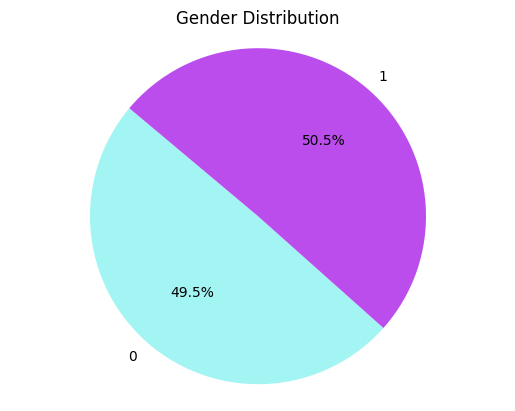

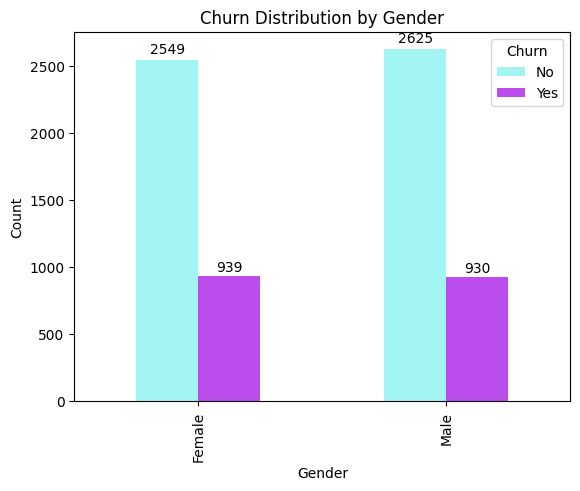

In [12]:
gender_data = data_df['gender']

gender_mapping = {"Male": 0, "Female": 1}

# Use LabelEncoder for encoding
le = LabelEncoder()
encoded_gender = le.fit_transform(gender_data)
gender_counts = Counter(encoded_gender)
pie_chart_labels = list(gender_counts.keys())
pie_chart_values = list(gender_counts.values())

colors = ['#A3F5F3', '#BB4DED']

plt.pie(pie_chart_values, labels=pie_chart_labels, autopct="%1.1f%%", startangle=140, colors=colors)
plt.title('Gender Distribution')
plt.axis('equal')

gender_loan_counts = pd.crosstab(data_df['gender'], data_df['Churn'])
gender_loan_counts.plot(kind='bar', stacked=False, color=colors)
plt.xlabel('Gender')
plt.ylabel('Count')
title = 'Churn Distribution by Gender'
plt.title(title)

# Get bar positions and heights
bars = plt.gca().patches  # Get all bars in the current plot
bar_positions = [bar.get_x() + bar.get_width() / 2 for bar in bars]  # Get center x of each bar
bar_heights = [bar.get_height() for bar in bars]  # Get height of each bar

# Annotate each bar with its count (total)
for i, (pos, height) in enumerate(zip(bar_positions, bar_heights)):
    plt.annotate(str(int(height)), (pos, height * 1.01), ha='center', va='bottom')  # Add some space above the bar with 1.01 multiplier

plt.legend(title='Churn')

plt.show()

This chart reveals a trend in customer churn, divided by gender. The vertical axis shows the number of customers who canceled, while the horizontal axis separates them by male and female. We see a higher churn rate among females, with 939 canceling compared to 930 males. While the difference is small, it's clear women are leaving at a slightly higher rate than men. However, the chart doesn't tell us why. Further investigation is needed to understand the reasons behind this gender gap in customer churn.

<b>Senior Citizen</b><br>
Bivariate analysis between SeniorCitizen and Churn. We included a univariant analysis of SeniorCitizen to better understand the representation of senior and non-senior people.

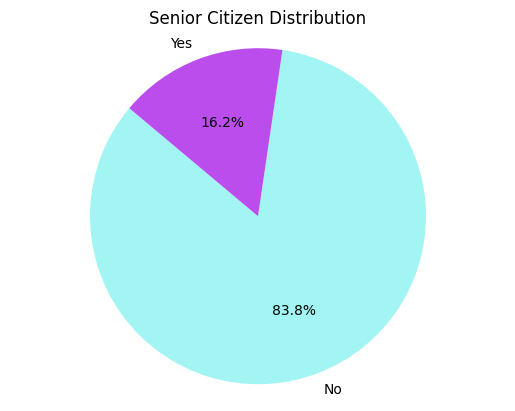

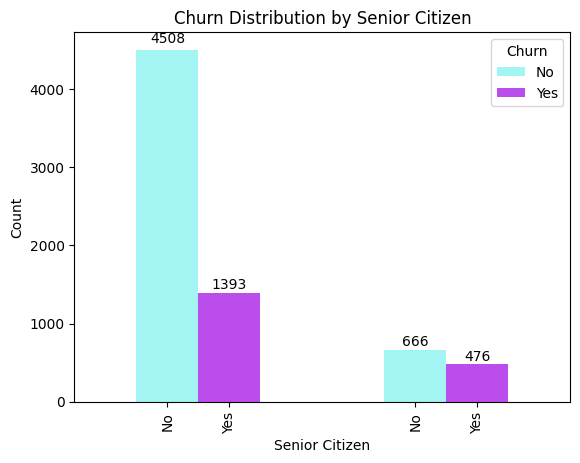

In [13]:
seniorCitizen_data = data_df['SeniorCitizen']

seniorCitizen_counts = Counter(seniorCitizen_data)

label_map = {0: "No", 1: "Yes"}
pie_chart_labels = [label_map[key] for key in seniorCitizen_counts.keys()]

pie_chart_values = list(seniorCitizen_counts.values())

colors = ['#A3F5F3', '#BB4DED']

plt.pie(pie_chart_values, labels=pie_chart_labels, autopct="%1.1f%%", startangle=140, colors=colors)
plt.title('Senior Citizen Distribution')
plt.axis('equal')

seniorCitizen_loan_counts = pd.crosstab(data_df['SeniorCitizen'], data_df['Churn'])

seniorCitizen_loan_counts.plot(kind='bar', stacked=False, color=colors)
plt.xlabel('Senior Citizen')
plt.ylabel('Count')
title = 'Churn Distribution by Senior Citizen'
plt.title(title)

# Get bar positions and heights
bars = plt.gca().patches  # Get all bars in the current plot
bar_positions = [bar.get_x() + bar.get_width() / 2 for bar in bars]  # Get center x of each bar
bar_heights = [bar.get_height() for bar in bars]  # Get height of each bar

category_labels = ["No", "No", "Yes", "Yes"] 

plt.xticks(bar_positions, category_labels)

# Annotate each bar with its count (total)
for i, (pos, height) in enumerate(zip(bar_positions, bar_heights)):
    plt.annotate(str(int(height)), (pos, height * 1.01), ha='center', va='bottom')  # Add some space above the bar with 1.01 multiplier

plt.legend(title='Churn')

plt.show()

Examining this churn distribution, a clear trend emerges regarding senior citizen status. The data indicates a higher churn rate among senior citizens. As evidenced by the bar graph, the number of senior citizens who churned is noticeably greater than those who did not. This suggests that senior citizens may find the service less engaging or encounter challenges using it, potentially leading to a higher likelihood of discontinuing service. Further investigation is necessary to pinpoint the specific reasons behind this disparity.

<b>Partner</b><br>
Bivariate analysis between Partner and Churn. We included a univariant analysis of Partner to better understand the representation of customers who have partners and those who do not.

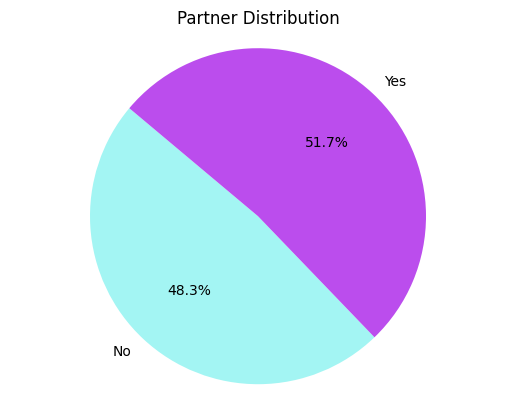

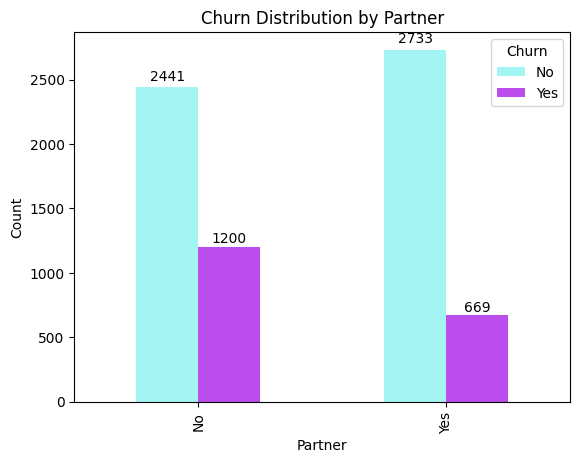

In [14]:
partner_data = data_df['Partner']

partner_mapping = {"No": 0, "Yes": 1}

# Use LabelEncoder for encoding
le = LabelEncoder()
encoded_partner = le.fit_transform(partner_data)

partner_counts = Counter(encoded_partner)
pie_chart_labels = list(["No", "Yes"])
pie_chart_values = list(partner_counts.values())

colors = ['#A3F5F3', '#BB4DED']

plt.pie(pie_chart_values, labels=pie_chart_labels, autopct="%1.1f%%", startangle=140, colors=colors)
plt.title('Partner Distribution')
plt.axis('equal')

partner_loan_counts = pd.crosstab(data_df['Partner'], data_df['Churn'])
partner_loan_counts.plot(kind='bar', stacked=False, color=colors)
plt.xlabel('Partner')
plt.ylabel('Count')
title = 'Churn Distribution by Partner'
plt.title(title)

# Get bar positions and heights
bars = plt.gca().patches  # Get all bars in the current plot
bar_positions = [bar.get_x() + bar.get_width() / 2 for bar in bars]  # Get center x of each bar
bar_heights = [bar.get_height() for bar in bars]  # Get height of each bar

# Annotate each bar with its count (total)
for i, (pos, height) in enumerate(zip(bar_positions, bar_heights)):
    plt.annotate(str(int(height)), (pos, height * 1.01), ha='center', va='bottom')  # Add some space above the bar with 1.01 multiplier

plt.legend(title='Churn')

plt.show()

As we can see from the graph a customer is more likely to churn if they have a partner. It's unclear how the services impact customers who have partners and needs a better understanding to decrease customer churning.

<b>Dependents</b><br>
Bivariate analysis between Dependents and Churn. We included a univariant analysis of Dependents to better understand the representation of customers who have dependents and those who do not.

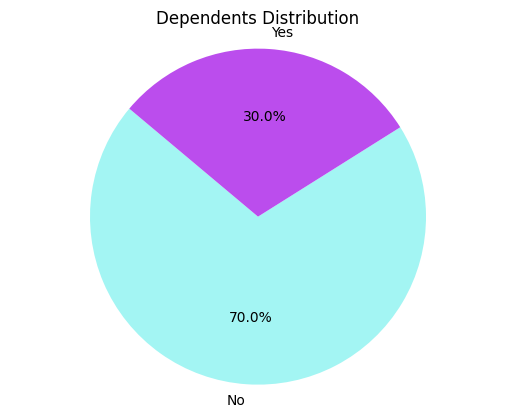

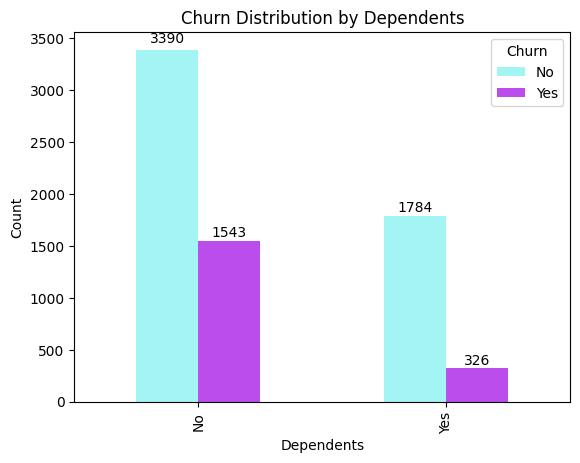

In [15]:
dependents_data = data_df['Dependents']

# Define encoding dictionary for handling missing values (if any)
dependents_mapping = {"No": 0, "Yes": 1}

# Use LabelEncoder for encoding
le = LabelEncoder()
encoded_dependents = le.fit_transform(dependents_data)

dependents_counts = Counter(encoded_dependents)
pie_chart_labels = list(["No", "Yes"])
pie_chart_values = list(dependents_counts.values())

colors = ['#A3F5F3', '#BB4DED']

plt.pie(pie_chart_values, labels=pie_chart_labels, autopct="%1.1f%%", startangle=140, colors=colors)
plt.title('Dependents Distribution')
plt.axis('equal')

dependents_loan_counts = pd.crosstab(data_df['Dependents'], data_df['Churn'])
dependents_loan_counts.plot(kind='bar', stacked=False, color=colors)
plt.xlabel('Dependents')
plt.ylabel('Count')
title = 'Churn Distribution by Dependents'
plt.title(title)

# Get bar positions and heights
bars = plt.gca().patches  # Get all bars in the current plot
bar_positions = [bar.get_x() + bar.get_width() / 2 for bar in bars]  # Get center x of each bar
bar_heights = [bar.get_height() for bar in bars]  # Get height of each bar

# Annotate each bar with its count (total)
for i, (pos, height) in enumerate(zip(bar_positions, bar_heights)):
    plt.annotate(str(int(height)), (pos, height * 1.01), ha='center', va='bottom')  # Add some space above the bar with 1.01 multiplier

plt.legend(title='Churn')

plt.show()

The data reveals a higher churn rate for customers with dependents. The "Yes" dependent bar dwarfs the "No" bar,
 indicating a significant difference.

In [16]:
# Compering the following tables (PhoneService, MultipleLines, InternetService, OnlineSecurity)

listofComparison = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity']

for col in listofComparison:
    gen_df = pd.DataFrame(
        data_df[[col, 'Churn']]
        .groupby('Churn')
        .value_counts()
        .reset_index()
    )


    fig = px.bar(
        data_frame=gen_df,
        x=col,
        y='count',
        facet_col= 'Churn',
        color=gen_df['Churn'].astype(str),
        title=f'Number of people that have {col}, compared to the targeted feature'
    )

    fig.update_layout(xaxis_title=f'{col} Outcome', yaxis_title='Number of customers')
    fig.show()

1. <b>Phone Service:</b>

There are more people with phone service compared to those that do not have any phone service. When looking at the chart indicating the customers that have left the business (Churn = Yes), it also displays that the majority of customers leaving the business have phone service.

`Question:` Could the service cause the customers to leave?

2. <b>Multiple Lines:</b>

Looking at the Multiple Lines bar chart, a larger amount of the people do not have multiple lines. The number of customers leaving the business is almost an even split between those that have multiple lines (850) and the people that do not have multiple lines (849). The people that have no phone service remain the same as indicated in the Phone Service bar chart, indicating that the data is clear and there are no inconsistencies between the Phone service column and the Multiple lines column.

3. <b>Internet Service:</b>

The majority of customers have DSL Internet Service, but looking at the customers that left the business, most of them have fiber optic internet service.

`Question:` Could the fiber optic internet service cause the customers to leave the business at possibly find new providers?

4. <b>Online Security:</b>

A large portion of the customers do not make use of online security. There are still more people that use security than those that do not have any security, indicating that it is still something that customers use and something that the business could invest in to make more customers use it. The amount of people not making use of internet service is still the same amount in the internet security column, meaning that the data is clear and there are no inconsistencies between the Internet Service column and the Online security column. Looking at the number of customers leaving the business, customers that do not make use of online security are in majority.

`Question:` Is the online security priced properly, should the business consider changing the price of security?

`Question:` Is the business offering good security and are there customers that did not have a good experience with the security that the business offers.

In [17]:
# Display the values in a pie graph
for col in listofComparison:
    gen_df = pd.DataFrame(
        data_df[[col, 'Churn']]
        .groupby('Churn')
        .value_counts()
        .reset_index()
    )


    fig = px.pie(
        data_frame=gen_df,
        values='count',
        facet_col= 'Churn',
        color=gen_df[col].index,
        names=gen_df[col],
        title=f'Number of people that have {col}, compared to the targeted feature'
    )

    fig.update_layout(xaxis_title=f'{col} Outcome', yaxis_title='Number of customers')
    fig.show()

Refering the pie chart, it displays an bivariate anlysis of the different values in the columns ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity'], compared to the targeted feature. Indicating the parts that the business should look into to lower the chances of their customers from leaving the business.

#### Isolate online Backup column and Churn

In [18]:
Ol_Bkup = data_df[["OnlineBackup","Churn"]]
Ol_Bkup

,OnlineBackup,Churn
0,Yes,No
1,No,No
2,Yes,Yes
3,No,No
4,No,Yes
...,...,...
7038,No,No
7039,Yes,No
7040,No,No
7041,No,Yes


Aggrigating Online Backup feature

In [19]:
OB_Summ= pd.DataFrame(
    Ol_Bkup.groupby("Churn")
    .value_counts()
    .reset_index()
)

OB_Summ

,Churn,OnlineBackup,count
0,No,Yes,1906
1,No,No,1855
2,No,No internet service,1413
3,Yes,No,1233
4,Yes,Yes,523
5,Yes,No internet service,113


Plotting data

In [20]:
ChurnN = OB_Summ[OB_Summ["Churn"] == "No"]
ChurnN

,Churn,OnlineBackup,count
0,No,Yes,1906
1,No,No,1855
2,No,No internet service,1413


In [21]:
ChurnY = OB_Summ[OB_Summ["Churn"] == "Yes"]
ChurnY

,Churn,OnlineBackup,count
3,Yes,No,1233
4,Yes,Yes,523
5,Yes,No internet service,113


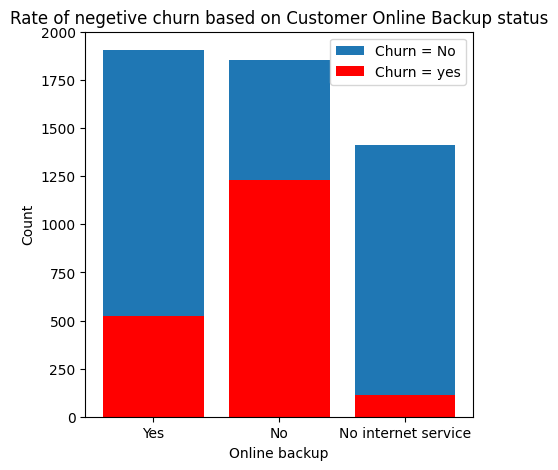

In [22]:
plt.figure(figsize = (5,5))
plt.bar(ChurnN["OnlineBackup"],ChurnN["count"])
plt.bar(ChurnY["OnlineBackup"],ChurnY["count"], color = ("r"))
plt.xlabel("Online backup")
plt.ylabel("Count") 
plt.title("Rate of negetive churn based on Customer Online Backup status")
plt.legend(labels={"Churn = No","Churn = yes"})
           
plt.show()

Take away

- The chances of ustomers returnig inf they have an online back up are and decresead further if 
    they did not have any internet connection
- however Customer Churn does shoe an increase ehen customers do not hasve an online backup thouh this is till 
    a marginasl difference compared to those who do not return 

Represent data in pie chart 

In [23]:
listofComparison = ["OnlineBackup"]
 
for col in listofComparison:
    gen_df = pd.DataFrame(
        data_df[[col, 'Churn']]
        .groupby('Churn')
        .value_counts()
        .reset_index()
    )
 
 
    fig = px.pie(
        data_frame=gen_df,
        values='count',
        facet_col= 'Churn',
        color=gen_df[col].index,
        names=gen_df[col],
        title=f'Number of people that have {col}, compared to the targeted feature'
    )
 
    fig.update_layout(xaxis_title=f'{col} Outcome', yaxis_title='Number of customers')
    fig.show()

#### Device Protection

 Importing  data

In [24]:
Protection = data_df[["DeviceProtection","Churn"]]
Protection

,DeviceProtection,Churn
0,No,No
1,Yes,No
2,No,Yes
3,Yes,No
4,No,Yes
...,...,...
7038,Yes,No
7039,Yes,No
7040,No,No
7041,No,Yes


Aggricating data

In [25]:
Dp_Smry= pd.DataFrame(
    Protection.groupby("Churn")
    .value_counts()
    .reset_index()
)
Dp_Smry

,Churn,DeviceProtection,count
0,No,No,1884
1,No,Yes,1877
2,No,No internet service,1413
3,Yes,No,1211
4,Yes,Yes,545
5,Yes,No internet service,113


Plotting data

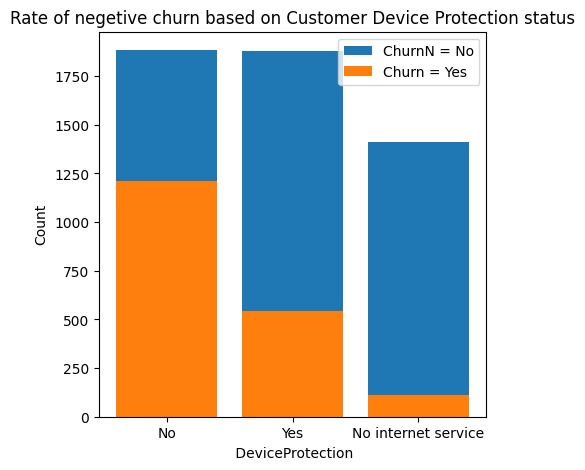

In [26]:
ChurnN = Dp_Smry[Dp_Smry["Churn"] == "No"]
ChurnY = Dp_Smry[Dp_Smry["Churn"] == "Yes"]

plt.figure(figsize = (5,5))
plt.bar(ChurnN["DeviceProtection"],ChurnN["count"])
plt.bar(ChurnY["DeviceProtection"],ChurnY["count"])
plt.xlabel(" DeviceProtection")
plt.ylabel("Count") 
plt.title("Rate of negetive churn based on Customer Device Protection status")
plt.legend(labels ={"Churn = Yes","ChurnN = No"},
           )
plt.show()

Take away 

There seems to be an overall lack in customer churn with respect to Device protection 
- even so we can see that even with the churn that is present, its heiest intake of customers is driven by the fact that 
    they do not have device protection this means that a customer is more likely to return  if they do not have device protaction than a a customer who either does or has no internet connection.

Represent data in pie chart 

In [27]:
listofComparison = ["DeviceProtection"]
 
for col in listofComparison:
    gen_df = pd.DataFrame(
        data_df[[col, 'Churn']]
        .groupby('Churn')
        .value_counts()
        .reset_index()
    )
 
 
    fig = px.pie(
        data_frame=gen_df,
        values='count',
        facet_col= 'Churn',
        color=gen_df[col].index,
        names=gen_df[col],
        title=f'Number of people that have {col}, compared to the targeted feature'
    )
 
    fig.update_layout(xaxis_title=f'{col} Outcome', yaxis_title='Number of customers')
    fig.show()

#### Tech support

Isolating needed column

In [28]:
Tech = data_df[["TechSupport","Churn"]]
Tech

,TechSupport,Churn
0,No,No
1,No,No
2,No,Yes
3,Yes,No
4,No,Yes
...,...,...
7038,Yes,No
7039,No,No
7040,No,No
7041,No,Yes


Aggricating data

In [29]:
TechS= pd.DataFrame(
    Tech.groupby("Churn")
    .value_counts()
    .reset_index()
)
TechS

,Churn,TechSupport,count
0,No,No,2027
1,No,Yes,1734
2,No,No internet service,1413
3,Yes,No,1446
4,Yes,Yes,310
5,Yes,No internet service,113


Plotting data

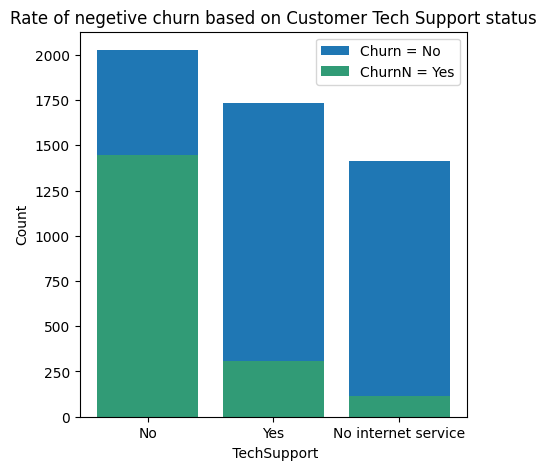

In [30]:
ChurnN = TechS[TechS["Churn"] == "No"]
ChurnY = TechS[TechS["Churn"] == "Yes"]

plt.figure(figsize = (5,5))
plt.bar(ChurnN["TechSupport"],ChurnN["count"])
plt.bar(ChurnY["TechSupport"],ChurnY["count"], color = "#319b76" )
plt.xlabel(" TechSupport")
plt.ylabel("Count") 
plt.title("Rate of negetive churn based on Customer Tech Support status")
plt.legend(labels ={"Churn = No","ChurnN = Yes"},
           )
plt.show()

Take away 

There seems to be an overall lack in customer churn with respect to Tech Support
- even so we can see that even with the churn that is present, its heiest intake of customers is driven by the fact that 
    they do not need Tech Support this means that a customer is more likely to return  if they do not have Tech Support than a a customer who either does or has no internet connection.

Represent data in pie chart 

In [31]:
listofComparison = ["TechSupport"]
 
for col in listofComparison:
    gen_df = pd.DataFrame(
        data_df[[col, 'Churn']]
        .groupby('Churn')
        .value_counts()
        .reset_index()
    )
 
 
    fig = px.pie(
        data_frame=gen_df,
        values='count',
        facet_col= 'Churn',
        color=gen_df[col].index,
        names=gen_df[col],
        title=f'Number of people that have {col}, compared to the targeted feature'
    )
 
    fig.update_layout(xaxis_title=f'{col} Outcome', yaxis_title='Number of customers')
    fig.show()

#### Paperless Billing

Isolating needed column

In [32]:
PaperBill = data_df[["PaperlessBilling","Churn"]]
PaperBill

,PaperlessBilling,Churn
0,Yes,No
1,No,No
2,Yes,Yes
3,No,No
4,Yes,Yes
...,...,...
7038,Yes,No
7039,Yes,No
7040,Yes,No
7041,Yes,Yes


Aggricating data

In [33]:
Paper= pd.DataFrame(
    PaperBill.groupby("Churn")
    .value_counts()
    .reset_index()
)
Paper

,Churn,PaperlessBilling,count
0,No,Yes,2771
1,No,No,2403
2,Yes,Yes,1400
3,Yes,No,469


 Plotting data

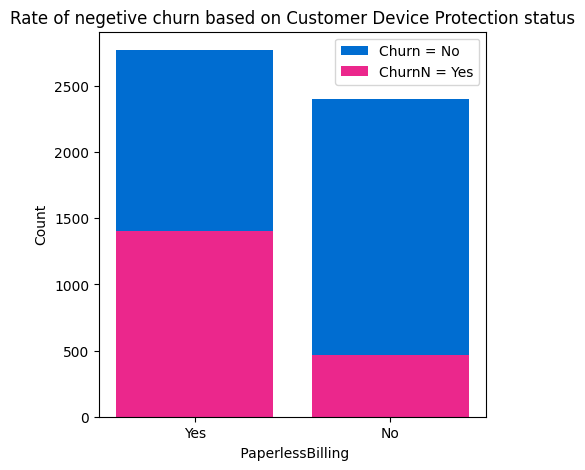

In [34]:
ChurnN = Paper[Paper["Churn"] == "No"]
ChurnY = Paper[Paper["Churn"] == "Yes"]

plt.figure(figsize = (5,5))
plt.bar(ChurnN["PaperlessBilling"],ChurnN["count"], color = "#006dd1")
plt.bar(ChurnY["PaperlessBilling"],ChurnY["count"], color ="#eb278c")
plt.xlabel(" PaperlessBilling")
plt.ylabel("Count") 
plt.title("Rate of negetive churn based on Customer Device Protection status")
plt.legend(labels ={"Churn = No","ChurnN = Yes"},
           )
plt.show()

Take away 

There seems to be an overall lack in customer churn with respect to Paperless Billing
- even so we can see that even with the churn that is present, its heiest intake of customers is driven by the fact that 
    they do not have Paperless Billing this means that a customer is more likely to return  if they do not have device protaction than a a customer who either does.

Represent data in pie chart 

In [35]:
listofComparison = ["PaperlessBilling"]
 
for col in listofComparison:
    gen_df = pd.DataFrame(
        data_df[[col, 'Churn']]
        .groupby('Churn')
        .value_counts()
        .reset_index()
    )
 
 
    fig = px.pie(
        data_frame=gen_df,
        values='count',
        facet_col= 'Churn',
        color=gen_df[col].index,
        names=gen_df[col],
        title=f'Number of people that have {col}, compared to the targeted feature'
    )
 
    fig.update_layout(xaxis_title=f'{col} Outcome', yaxis_title='Number of customers')
    fig.show()

## Payment Method
There are a four different payment methods that customers make use of. Lets see what correlation it has with the churn outcome

Represent data in pie chart 

In [36]:
listofComparison = ["PaperlessBilling"]
 
for col in listofComparison:
    gen_df = pd.DataFrame(
        data_df[[col, 'Churn']]
        .groupby('Churn')
        .value_counts()
        .reset_index()
    )
 
 
    fig = px.pie(
        data_frame=gen_df,
        values='count',
        facet_col= 'Churn',
        color=gen_df[col].index,
        names=gen_df[col],
        title=f'Number of people that have {col}, compared to the targeted feature'
    )
 
    fig.update_layout(xaxis_title=f'{col} Outcome', yaxis_title='Number of customers')
    fig.show()

In [37]:
df_data = ['StreamingTV', 'StreamingMovies', 'PaymentMethod', 'Churn']
df1 = data_df[df_data]
df1.isnull().sum()

StreamingTV        0
StreamingMovies    0
PaymentMethod      0
Churn              0
dtype: int64

In [38]:
#Now we show the data
# Visualizing the different payment methods
labels = df1['PaymentMethod'].unique()
values = df1['PaymentMethod'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(title_text="Different Payment method outlook")
fig.show()

In [39]:
fig = px.histogram(data_df, x="Churn", color="PaymentMethod", title='Payment method comparison with churn')
fig.update_layout(width=700, height=500, bargap=.1)
fig.show()

## Streaming
The data has two different types of streaming, Movie and TV. Lets see how the data is interpreted. 

Staring off of Streaming MOvies

In [40]:
labels = df1['StreamingMovies'].unique()
values = df1['StreamingMovies'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(title_text="Streaming Movies Distribution")
fig.show()

In [41]:
fig = px.histogram(df1, x="Churn", color="StreamingMovies", title="Streaming Movies and Churn Visualization")
fig.show()

Now for the Streaming TV

In [42]:
labels = df1['StreamingTV'].unique()
values = df1['StreamingTV'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(title_text="Streaming TV Distribution")
fig.show()

In [43]:
fig = px.histogram(df1, x="Churn", color="StreamingTV", title="Streaming TVs and Churn Visualization")
fig.show()

Streaming outcome

From the data we can see that a mojority of the people don't have any of the subcribtions as well as most who don't have a subcribtion, Churn

Outcome<br>
WE see that the majority of customers use Electronic check as their main payment method. And that most of the ones who do churn make use of this payment method as well

<a id  = "21"></a>
### Monthly Charges
The 'MonthlyCharges' column represents the amount of money each customer pays for a subscription to one or more of the services  the company provides.


In [44]:
missing_values = data_df['MonthlyCharges'].isnull().sum()
print(f"missing values: {missing_values}")
only_numbers = data_df['MonthlyCharges'].dtype == 'float64'
print(f"Only numeric values: {only_numbers}")
print(f"Total number of values: {len(data_df['MonthlyCharges'])}")


missing values: 0
Only numeric values: True
Total number of values: 7043


There are no missing values and only numeric values in the column. 

Box plot: Identifying outliers

In [45]:
#Outliers Identification
Q1 = data_df['MonthlyCharges'].quantile(0.25)
Q3 = data_df['MonthlyCharges'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#isolate outliers
outliers_indexes = []
counter = 0
for index, row in enumerate(data_df['MonthlyCharges']):
    if row < lower_bound:
        outliers_indexes.append(index)
    else:
        if row > upper_bound:
            outliers_indexes.append(index)
Outliers_df = data_df['MonthlyCharges'].loc[outliers_indexes] 

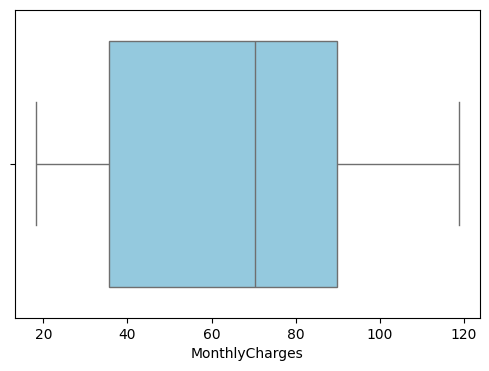

Number of outliers: 0


In [46]:
#Plot the box plot of the Monthly charges column
plt.figure(figsize=(6,4))
sns.boxplot(x=data_df['MonthlyCharges'], color='skyblue')
sns.swarmplot(x=Outliers_df, color='red', label='Outliers')
plt.show() 
print(f"Number of outliers: {len(Outliers_df)}")

In [47]:
#function to plot histogram
def plt_hist(data):
    plt.figure(figsize=(5, 5))
    sns.histplot(data, kde=True, bins=20)
    plt.title(f'Distribution of the {data.name}')
    plt.xlabel(f'{data.name}')
    plt.xticks(rotation=5)
    plt.show()
    return

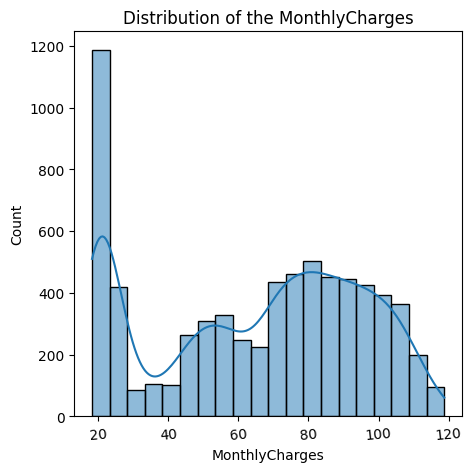

Skewness coefficient: -0.22	Kurtosis coefficent: -1.26


In [48]:
#skewness
skew_coef =data_df['MonthlyCharges'].skew().__round__(2)
kurt_coeff = data_df['MonthlyCharges'].kurt().__round__(2)
plt_hist(data_df['MonthlyCharges'])
print(f"Skewness coefficient: {skew_coef}\tKurtosis coefficent: {kurt_coeff}")


The kurtosis coefficient (k < 0): Tells us that the data is unbalanced. It has a heavier tail to the right. From the diagram we see a spike at around $20, this odd spike is what may be causing the skewness value. This spike will be removed.   

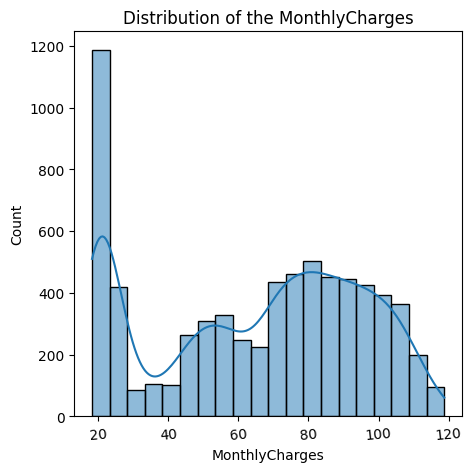

In [49]:
#drop rows where monthly charges are less than 25
data_df = data_df[data_df['MonthlyCharges'] > 10]
plt_hist(data_df['MonthlyCharges'])

The monthly charges column is multimodal distributed. This means the data might be segmented into different groups such as, lower, middle and higher monthly charges based on their subscription choices. 

Monthly Charges and Churn <br>
The relationship between the monthly charges and churn will be evaluated.  

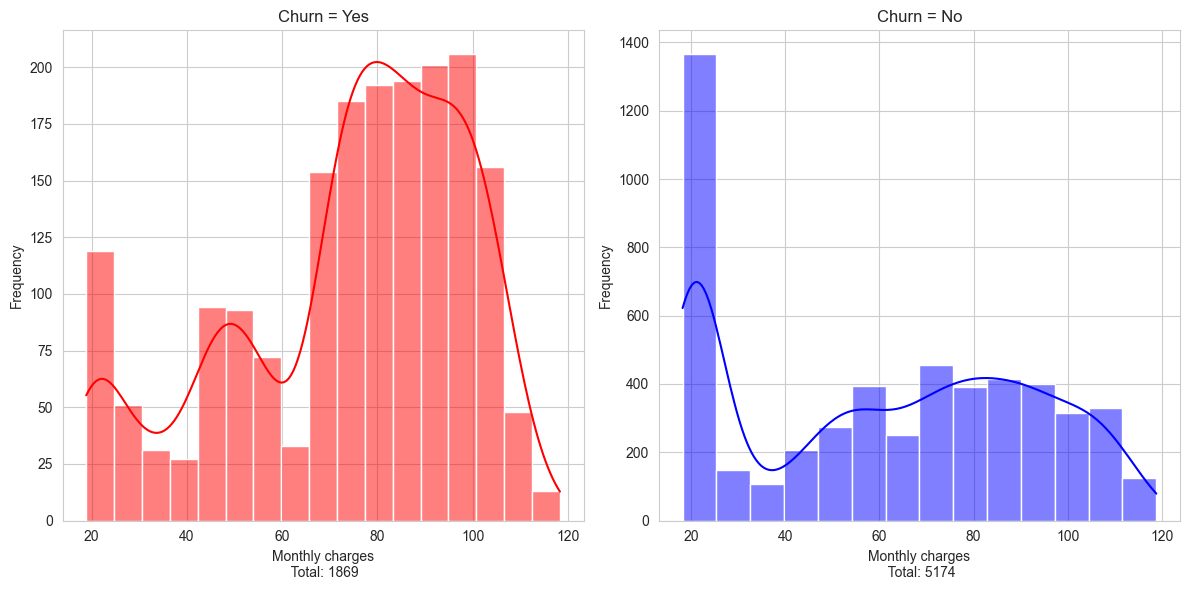

Percentage of customers who leave: 26.54%


In [50]:
yes = data_df[data_df['Churn'] == 'Yes']
no = data_df[data_df['Churn'] == 'No']
# Set the style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Churn = Yes
sns.histplot(data=data_df[data_df['Churn'] == 'Yes'], x='MonthlyCharges', ax=axes[0], kde=True, color='red')
axes[0].set_title('Churn = Yes')
axes[0].set_xlabel(f'Monthly charges\n Total: {len(yes)}')
axes[0].set_ylabel('Frequency')


# Plot for MonthlyCharges Vs. Churn = no
sns.histplot(data=data_df[data_df['Churn'] == 'No'], x='MonthlyCharges', ax=axes[1], kde=True, color='blue')
axes[1].set_title('Churn = No')
axes[1].set_xlabel(f'Monthly charges\n Total: {len(no)}')
axes[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()
print(f"Percentage of customers who leave: {(len(yes)*100/ len(data_df)).__round__(2)}%")


Customers who pay montthly charges between $60 and $80 have the highest rate of churn, these are customers who are likely to leave. The lowest churn rate is between $80 and $90, this means even though customers are churning they are more likely to stay than to churn. There is a higher number of customers who do not churn in the lower monthly payment region than those who do. however, the churn **rate** and non-churn rate appears to be almost equal for values above $100. 

<a id  = "22"></a>
### Total Charges
The total charges column represent the total amount charged to the customer throughout their subscription period (tenure). It can be compromised from one or more service subscriptions. 

In [51]:
missing_values = data_df['TotalCharges'].isnull().sum()
print(f"missing values: {missing_values}")
only_numbers = data_df['TotalCharges'].dtype == 'float64'
print(f"Only numeric values: {only_numbers}")
print(f"Total number of values: {len(data_df['TotalCharges'])}")


missing values: 0
Only numeric values: True
Total number of values: 7043


The total charges column appears to have non-numeric vaues. these values must be:
- checked to see if they are numbers stored as strings, 
- if they are numbers stored as strings conversion will take place, else, these values will be repllaced by NAN using pandas,then replaced with the mean of the column.

In [52]:
#replace any empty strings with NAN
data_df['TotalCharges'] = data_df['TotalCharges'].replace(" ", np.nan)

#convert object to numberic if there are letters the following
#code will throw an error
data_df['TotalCharges'] = pd.to_numeric(data_df['TotalCharges'])
print(f"New datatype: {data_df['TotalCharges'].dtype}")
print(f"Missing values: {data_df['TotalCharges'].isna().sum()}")

New datatype: float64
Missing values: 0


There are 7 missing values and these missing values will be replaced with the mean of the column.

In [53]:
#fill missing values with mean
data_df['TotalCharges'].fillna(
    data_df['TotalCharges'].mean(), inplace=True
)
print(f"Missing values: {data_df['TotalCharges'].isna().sum()}")

Missing values: 0


#### Outliers

In [54]:
#find the quartile ranges to identify outliers
Q1= data_df['TotalCharges'].quantile(0.25) 
Q3= data_df['TotalCharges'].quantile(0.75)

inter_quartile_range = Q3-Q1

#find the inter quartile ranges
lower_bound = Q1 - (1.5*inter_quartile_range)
upper_bound = Q3 + (1.5*inter_quartile_range)

#isolate outliers
outliers_indexes = []
counter = 0
for index, row in enumerate(data_df['TotalCharges']):
    if row < lower_bound:
        outliers_indexes.append(index)
    else:
        if row > upper_bound:
            outliers_indexes.append(index)
print(f"Total Number of Outliers: {len(outliers_indexes)}") 

Total Number of Outliers: 0


We see the same phenomen as before, where there are no outliers. Thus a box plot will not be plotted but a histogram to check for any spikes.

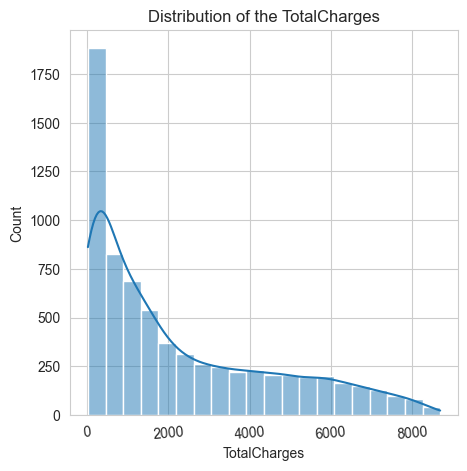

In [55]:
#plot the histogram
plt_hist(data_df['TotalCharges'])


We see a spike around 0 <TotalCharges <= 400, this spike may affect the model during training hence it will be removed.

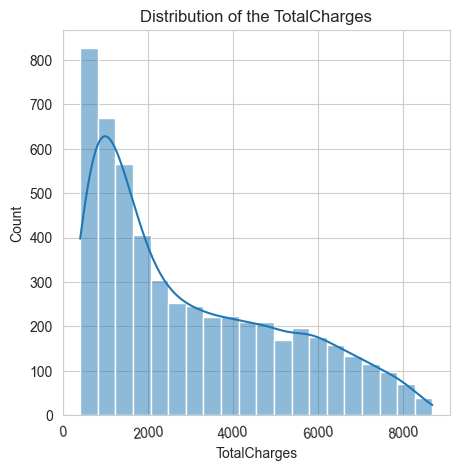

count    5288.000000
mean     2990.464184
std      2195.872433
min       400.300000
25%      1114.400000
50%      2285.275220
75%      4654.875000
max      8684.800000
Name: TotalCharges, dtype: float64


In [56]:
data_df = data_df[data_df['TotalCharges'] > 400]
plt_hist(data_df['TotalCharges'])
print(data_df['TotalCharges'].describe())

The data is right skewed (mean > median), thus there are more higher total chargers than there aare lower.

#### Total Charges and Churn

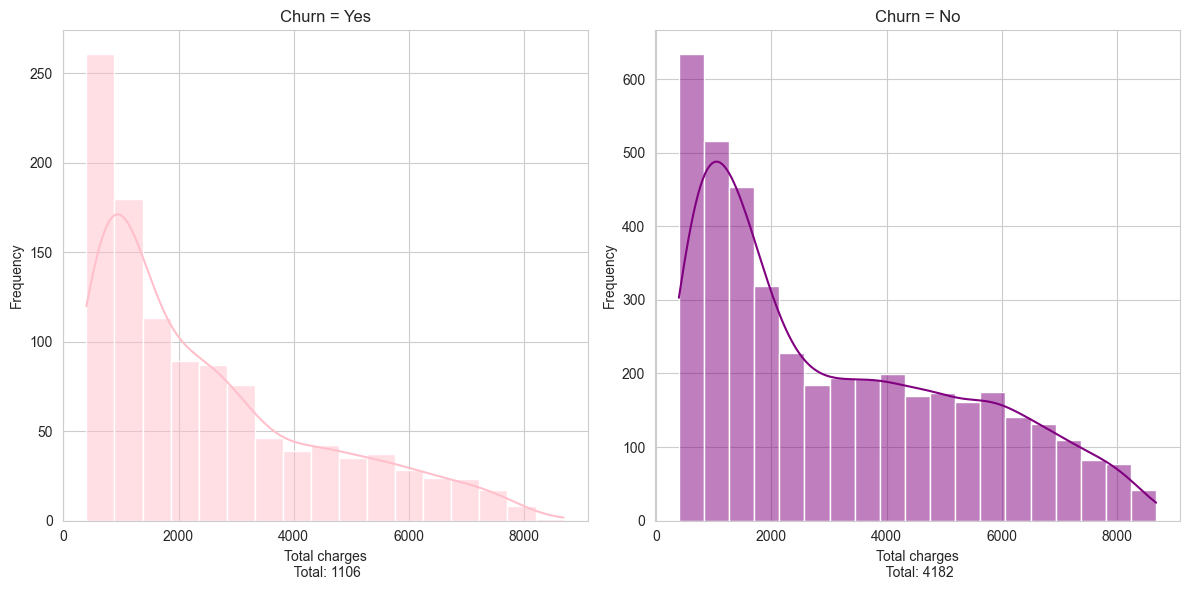

Percentage of customers who leave: 20.92%


In [57]:
yes = data_df[data_df['Churn'] == 'Yes']
no = data_df[data_df['Churn'] == 'No']

sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Churn = Yes
sns.histplot(data=data_df[data_df['Churn'] == 'Yes'], x='TotalCharges', ax=axes[0], kde=True, color='pink')
axes[0].set_title('Churn = Yes')
axes[0].set_xlabel(f'Total charges\n Total: {len(yes)}')
axes[0].set_ylabel('Frequency')


# Plot for MonthlyCharges Vs. Churn = no
sns.histplot(data=data_df[data_df['Churn'] == 'No'], x='TotalCharges', ax=axes[1], kde=True, color='purple')
axes[1].set_title('Churn = No')
axes[1].set_xlabel(f'Total charges\n Total: {len(no)}')
axes[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()
print(f"Percentage of customers who leave: {(len(yes)*100/ len(data_df)).__round__(2)}%")


Customers with total chargers > 4000, have a lower churn rate that customers with total charges between [400, 800], there are more customers staying in the region total costs > 4000 than leaving. The highest number of customers who are staying have total chargers between 400 and 2000.

#### Tenure

In [58]:
#Check the datatype we expect int. if object there are problems
print(f"Data type: {data_df['tenure'].dtype}")
#missing values
print(f"Missing values: {data_df['tenure'].isnull().sum()}")
#min and max values
print(f"Min: {data_df['tenure'].min()} \t Max: {data_df['tenure'].max()}")

Data type: int64
Missing values: 0
Min: 0 	 Max: 72


In [59]:
#Outliers
#find the quartile ranges to identify outliers
Q1= data_df['tenure'].quantile(0.25) 
Q3= data_df['tenure'].quantile(0.75)

inter_quartile_range = Q3-Q1

#find the inter quartile ranges
lower_bound = Q1 - (1.5*inter_quartile_range)
upper_bound = Q3 + (1.5*inter_quartile_range)

#isolate outliers
outliers_indexes = []
counter = 0
for index, row in enumerate(data_df['tenure']):
    if row < lower_bound:
        outliers_indexes.append(index)
    else:
        if row > upper_bound:
            outliers_indexes.append(index)
print(f"Total Number of Outliers: {len(outliers_indexes)}") 

Total Number of Outliers: 0


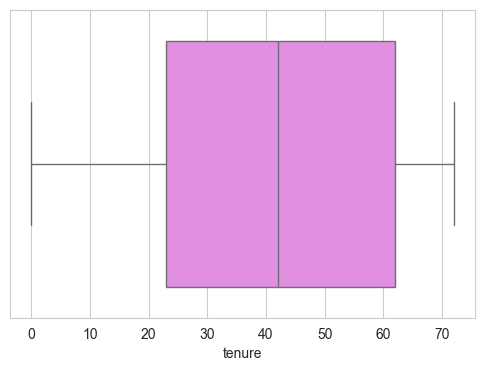

Number of outliers: 0
count    5288.000000
mean       41.666225
std        21.211803
min         0.000000
25%        23.000000
50%        42.000000
75%        62.000000
max        72.000000
Name: tenure, dtype: float64


In [60]:
#Plot the box plot of the Monthly charges column
plt.figure(figsize=(6,4))
sns.boxplot(x=data_df['tenure'], color='violet')
sns.swarmplot(x=Outliers_df, color='red', label='Outliers')
plt.show() 
print(f"Number of outliers: {len(Outliers_df)}")
print(data_df['tenure'].describe())

There is relatively more customers with a higher tenure than there are with a lower tenure. the data is positively skewed.

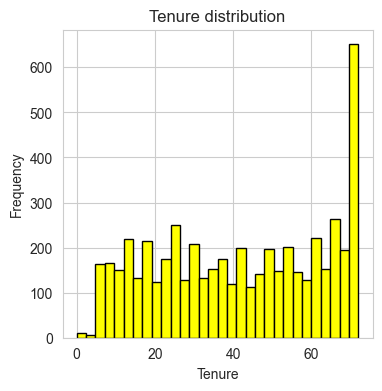

In [61]:
#histogram plot for tenure
plt.figure(figsize=(4,4))
plt.hist(data_df['tenure'], bins=30,color='yellow',edgecolor='black')
plt.title('Tenure distribution')
plt.xlabel('Tenure')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


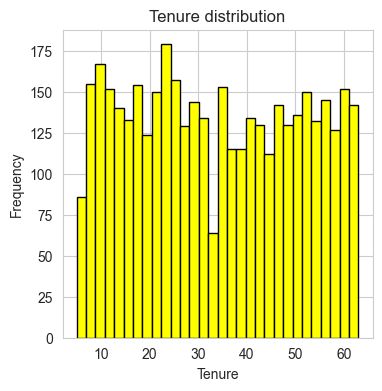

In [62]:
data_df = data_df[((data_df['tenure']) > 4) & ((data_df['tenure']) < 64)]
#histogram plot for tenure
plt.figure(figsize=(4,4))
plt.hist(data_df['tenure'], bins=30,color='yellow',edgecolor='black')
plt.title('Tenure distribution')
plt.xlabel('Tenure')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


#### Tenure and Churn
The relationship betweeen tenure and churn will be modeled next.

In [63]:
#Group tenure based on churn == no or churn == yes
churn_df = data_df[data_df['Churn'] == 'Yes'][['tenure']]
no_churn_df = data_df[data_df['Churn'] == 'No'][['tenure']]
print(f"Churn totals:\n\tYes: {len(churn_df)}\tNo: {len(no_churn_df)}")
print(f"Percentange of customers who churn: {round(len(churn_df)*100/(len(churn_df)+len(no_churn_df)),2)}%")

Churn totals:
	Yes: 1026	No: 3057
Percentange of customers who churn: 25.13%


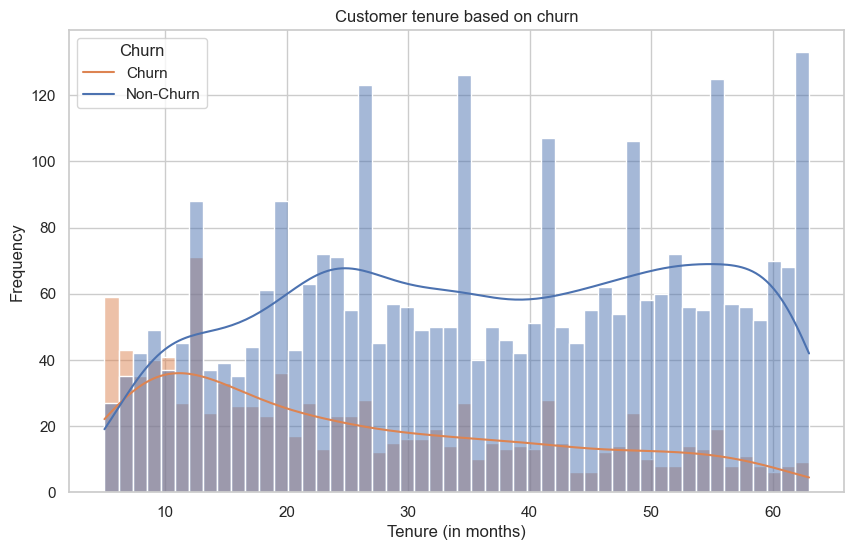

In [64]:
sns.set(style="whitegrid")

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=data_df, x='tenure', hue='Churn', 
             bins=50, kde=True)
plt.title('Customer tenure based on churn')
plt.xlabel('Tenure (in months)')
plt.ylabel('Frequency')
plt.legend(title='Churn', labels=['Churn', 'Non-Churn'])
plt.show()

Customers with a higher tenure are less likely to churn over customers with a lower tenure. More customers churn in the perioid less than 10 months.

In [65]:
#put aside un-transformed data for rf mode
data_df.to_csv("src/data/data_for_rf.csv", index = False)

<a id  = "3"></a>
## Data Transformation


This section will be dedicated to encoding the data before using it to train the ml models. This is done to imporve the performance of the ml model, to numereically represent the features and to avoid bais by the model (nlp).

- **Label encoding**: sutable for data with an intrinsic order in the categories (low medium high).
  - SeniorCitizen
  - Churn
- **One hot encoding**: Suitable for when the order is not important (this will be the rest of the columns).


In [66]:
def ohe_columns(data):
    columns_to_ohe = ['gender', 'Partner','Dependents','PhoneService',
                      'MultipleLines', 'InternetService', 'OnlineSecurity',
                      'OnlineBackup', 'DeviceProtection', 'TechSupport',
                      'StreamingTV', 'StreamingMovies', 'Contract',
                      'PaperlessBilling', 'PaymentMethod']
    ohe = OneHotEncoder(
       use_cat_names = True,
       cols = columns_to_ohe 
    )
    ohe_df = ohe.fit_transform(data)
    return ohe_df

In [67]:
def label_encoding(data):
    label_encoding = LabelEncoder()
    columns_to_LE = ['Churn', 'SeniorCitizen']
    
    for col in columns_to_LE:
        data[col] = label_encoding.fit_transform(data[col]).astype(int)
    return data

In [68]:
#Encode columns
data_df = data_df.pipe(label_encoding).pipe(ohe_columns)


<a id  = "4"></a>
## Models
- Logistic regression
- Random Forest

In [69]:
#split data
X = data_df.drop(columns=['Churn'])
Y = data_df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"Length of training data: {len(X_train)}\nLength of testing data {len(X_test)}")

Length of training data: 3266
Length of testing data 817


In [70]:
#Get baseline accuracy
acc_baseline = y_train.value_counts(normalize=True).max()*100
print(f"The accuracy baseline is: {round(acc_baseline,2)}%")

The accuracy baseline is: 75.05%


<a id  = "41"></a>
### Logistic Regression

hyper-parameters to tune:
- C : Regularization is used to prevent overfitting, this parameter controls the strength of regularization.
- max_iterator: These are the maximum number of iterators taken for the solver to converge. this prevents the algorithm from running forever.

#### Grid Search
Grid search will be used to find the best combination of hyperparameters values for the model.

In [71]:
#Get the optimal hyper parameter configurations
param_grid = {
    'C': [0.0001, 0.001, 0.1, 1.0, 10],
    #'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
    'max_iter': [100, 500, 1000, 2500]
}

#grid search object
grid_sobj = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')

#fit the grid search object to the data
grid_sobj.fit(X_train, y_train)
best_params = grid_sobj.best_params_
print(f"Best hyperparams: {best_params}")

Best hyperparams: {'C': 0.1, 'max_iter': 2500}


In [72]:
#Build model
model_lr = make_pipeline(
    LogisticRegression(max_iter=best_params['max_iter'],
                       solver='lbfgs',
                       C=best_params['C'])
)

#fit model
model_lr.fit(X_train,y_train)

Pipeline(steps=[('logisticregression',
                 LogisticRegression(C=0.1, max_iter=2500))])

Training and validation accuracy score for the regression model:

In [73]:
reg_train_acc = model_lr.score(X_train, y_train)
reg_test_acc = model_lr.score(X_test, y_test)

print(f"The training accuracy score is: {round(reg_train_acc*100,2)}%")
print(f"The testing accuracy score is: {round(reg_test_acc*100,2)}%")


The training accuracy score is: 80.16%
The testing accuracy score is: 79.93%


In [74]:
#Extract and view important features
def ft_importance(model_nr, model):
    if(model_nr == 1):
        # Extract features and their coefficients
        coef = model.named_steps["logisticregression"].coef_[0]
        ft = X_train.columns
    
    else:
        coef = model.named_steps["randomforestclassifier"].feature_importances_
        ft = model.named_steps['randomforestclassifier'].feature_names_in_
    
    # Convert to Pandas Series
    ft_importance = pd.Series(
        np.exp(coef), index=ft
        ).sort_values(ascending=False)
    
    #Plot ft importance
    # Create horizontal bar chart of feature importances
    #Plot ft importance
    # Create horizontal bar chart of feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x=ft_importance[:16].values, y=ft_importance[:16].index, palette='viridis')
    plt.title('Feature Importance')
    plt.xlabel('Gini Importance')
    plt.ylabel('Features')
    plt.show()
    return

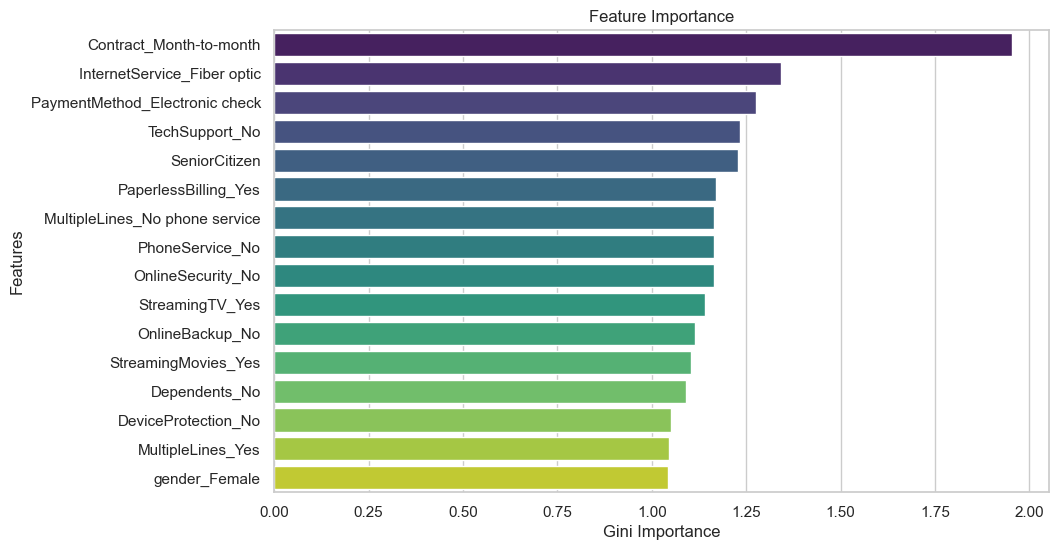

In [75]:
ft_importance(1, model_lr)

Having a partner that also uses the telecom streaming serivices, highly impacts the churn rate of the customer and having multiple affects if the customer will churn or not. customers with multiple lines are likely not to churn.

save model:

In [76]:
joblib.dump(model_lr, 'artifacts/model_lr.pk1') 

['artifacts/model_lr.pk1']

The regression model predicted with an accuracy of 78.75%, adusting the solver type only improved the accuracy score by 1% fro 77%. The regression model is incredibly resource intensive and not suitable for this large dataset. Random forest model will be investigated.

<a id  = "42"></a>
### Random Forest


#### Feature Engineering

1. The tenure column will be converted to categorical by having the values grouped into long-term, medium term and short term tenure. this column will then be labe encoded because it has an intrinsic order.

In [77]:
#read in data set aside for rf model
data_df2 = pd.read_csv("src/data/data_for_rf.csv")
print(data_df2.shape)

(4083, 20)


In [78]:
#find the range of tenure
range_tenure = data_df2['tenure'].max() - data_df2['tenure'].min()
num_of_cat = 3

#width of groups
width = range_tenure/3

#edges
short_term_max = data_df2['tenure'].min() + width
med_term_max = short_term_max + width
#any value larger than med_term_max will be long term
tenure_cat = []
for tenure in data_df2['tenure']:
    if tenure <= short_term_max:
        tenure_cat.append(0)
    elif (tenure > short_term_max) & (tenure <= med_term_max):
        tenure_cat.append(1)
    else:
        tenure_cat.append(2)

# create a new column and drop the old one
data_df2['tenure_cat'] = tenure_cat
data_df2.drop(columns=['tenure'], inplace=True)        


Combine Partner and dependents into family, then replace it with a 1 or 0 for yes (have family) and no (does not have family).

In [79]:
data_df2['family'] = (data_df2['Partner'].eq('Yes') | data_df2['Dependents'].eq('Yes')).astype(int)
data_df2.drop(columns=['Partner', 'Dependents'], inplace = True)
#print(data_df2['family'])

If a user has internet services that they are already subscribed to online security and back up. so this data is redundant.

In [80]:
data_df2.drop(columns=['OnlineSecurity', 'OnlineBackup'], inplace=True)
print(data_df2.shape)

(4083, 17)


combine stramingTV and streamingMovies into one column called streaming

In [81]:
data_df2['Streaming'] = 'No'
for index, row in data_df2.iterrows():
    if row['StreamingMovies'] == 'Yes' and row['StreamingTV'] == 'Yes':
        data_df2.at[index, 'Streaming'] = 'both'
    elif row['StreamingMovies'] == 'Yes':
        data_df2.at[index, 'Streaming'] = 'M'
    elif row['StreamingTV'] == 'Yes':
        data_df2.at[index, 'Streaming'] = 'TV'
#print(data_df2['Streaming'].unique())
data_df2.drop(columns=['StreamingMovies', 'StreamingTV'], inplace=True)
#print(data_df.columns)
print(data_df2.shape)

(4083, 16)


In [82]:
print(data_df2.columns)

Index(['gender', 'SeniorCitizen', 'PhoneService', 'MultipleLines',
       'InternetService', 'DeviceProtection', 'TechSupport', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'tenure_cat', 'family', 'Streaming'],
      dtype='object')


##### Transform the new data

In [83]:
def label_encoding2(data):
    label_encoding = LabelEncoder()
    columns_to_LE = ['Churn', 'SeniorCitizen', 'tenure_cat']
    
    for col in columns_to_LE:
        data[col] = label_encoding.fit_transform(data[col]).astype(int)
    return data

In [84]:
def ohe_columns2(data):
    columns_to_ohe = ['gender', 'PhoneService', 'MultipleLines',
       'InternetService', 'DeviceProtection', 'TechSupport',
       'Contract', 'PaperlessBilling', 'PaymentMethod','family', 
       'Streaming']
    ohe = OneHotEncoder(
       use_cat_names = True,
       cols = columns_to_ohe 
    )
    ohe_df = ohe.fit_transform(data)
    return ohe_df

In [85]:
#Encode columns
data_df2 = label_encoding2(data_df2)
data_df2 = ohe_columns2(data_df2)

Split dataframe again

In [86]:
#split data
X = data_df2.drop(columns=['Churn'])
Y = data_df2['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"Length of training data: {len(X_train)}\nLength of testing data {len(X_test)}")

Length of training data: 3266
Length of testing data 817


In [87]:
def plt_acc(training_acc, validation_acc, esitmator, max_depths):
    train_acc_df = pd.DataFrame(training_acc, columns=['accuracy'])
    val_acc_df = pd.DataFrame(validation_acc, columns=['accuracy']) 
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=train_acc_df, x=max_depths, y='accuracy', palette=['blue'], marker='o', linestyle='-', ci=None)
    sns.lineplot(data=val_acc_df, x=max_depths, y='accuracy', palette=['red'], marker='o', linestyle='-', ci=None)
    plt.title(f'Training and Validation accuracy scores for Random Forest (n_estimators={esitmator})')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.legend(labels=['Training', 'Validation'])
    plt.show()
    return

In [88]:
def train_rf(estimator):
    training_acc = []
    validation_acc= []
    max_depths_range = range(1,30)
    for max_depth in max_depths_range:
            # Initialize Random Forest model with current hyperparameters
            rf_model = RandomForestClassifier(
                n_estimators=estimator, 
                max_depth=max_depth, random_state=42)
            
            rf_model.fit(X_train, y_train)
            
            training_acc.append(rf_model.score(X_train,y_train))
            validation_acc.append(rf_model.score(X_test,y_test))
    plt_acc(training_acc, validation_acc, estimator, list(max_depths_range))
    return 

The following section of code was ran with a higher number of estimators. This took alot of time. hence the estimators will be reduced to the relevent numbers, because after a while it started repeating.

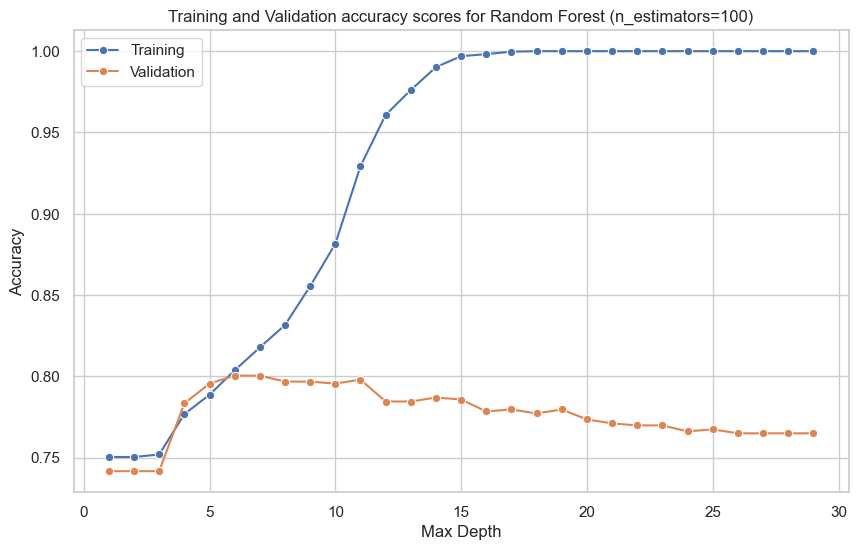

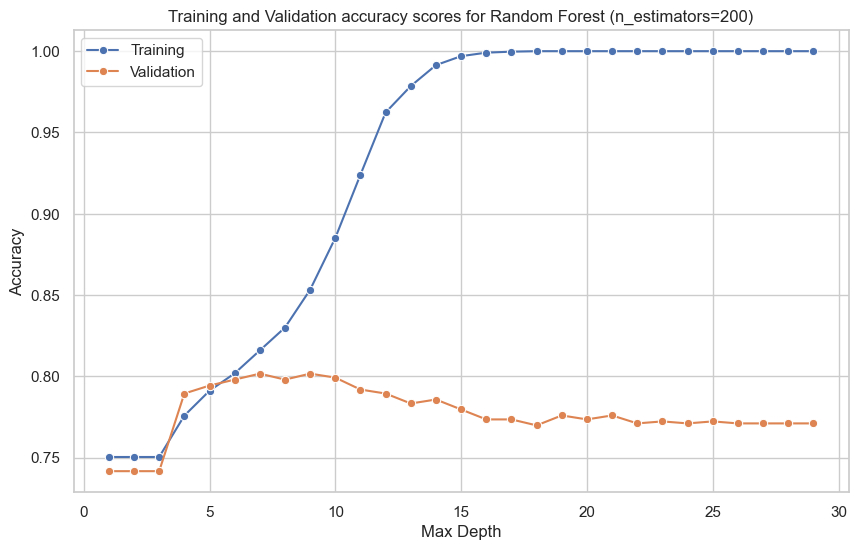

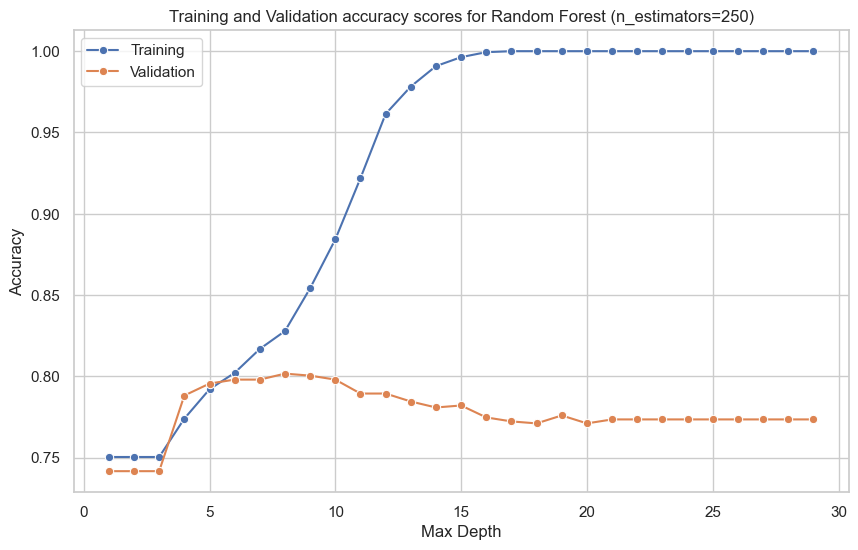

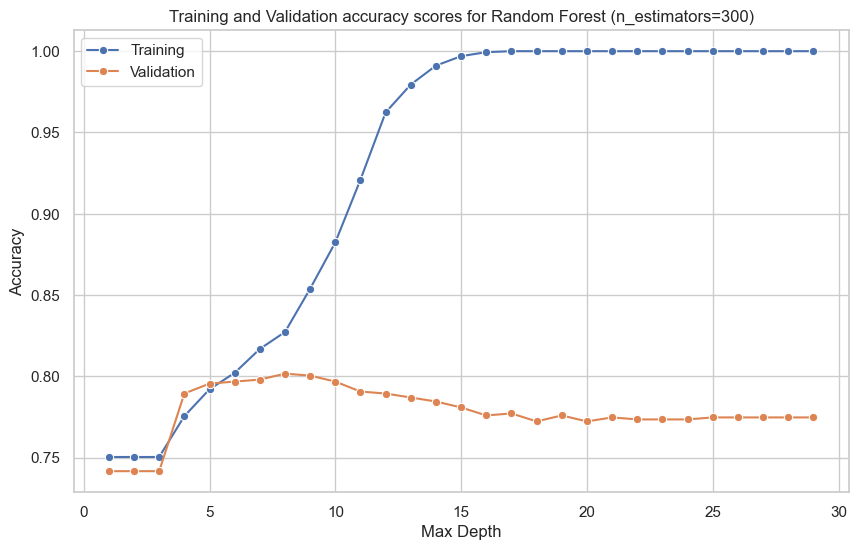

In [89]:
n_estimators_range = [100, 200, 250, 300]

for n in n_estimators_range:
    train_rf(n)

We see that at n_estimators = 250, and max depth = 8, we get the highest accuracy score.

Train rf final model:

In [90]:
rf_model = RandomForestClassifier(
    n_estimators=250, 
        max_depth=8, random_state=42)
            
rf_model.fit(X_train, y_train)
 # Evaluate the model
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"The accuracy score is: {round(accuracy*100, 2)}% after feature training using the final Random Forest model.")


The accuracy score is: 80.17% after feature training using the final Random Forest model.


Save model:

In [91]:
 # Save the model
joblib.dump(rf_model, 'artifacts/rf_model.pk2')

['artifacts/rf_model.pk2']

<a id  = "5"></a>
### For the DASH

#### Changes:<br>
Inputs:<br>
- No seperate dependants and partner this has been replaced with 1 column called family (1/0) 1 for Yes, 0 for No.(enter 1/0)
- Movie and TV Streaming has been combined to Streaming:
    - 'M': movies,
    - 'both': both,
    - 'TV': TV,
    - 'No': no-internet
All columns: <br>
- relevant columns: 'gender', 'SeniorCitizen', 'PhoneService', 'MultipleLines',
       'InternetService', 'DeviceProtection', 'TechSupport', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
        'tenure_cat', 'family', 'Streaming'.

Before feeding input into model you can encode using (2nd encoding functions): <br>
data_df = label_encoding2(data_df)
data_df = ohe_columns2(data_df)

